# <center> Sweeping variables demonstration

### <center> In this demo you will sweep the amplitude of a pulse in loopback to demonstrate control over the QICK. 

We will sweep in two ways:
* Within the QICK assembly language (advantage: faster, disadvantage: cannot be used to sweep the readout frequency)
* With a Python outer loop (advantage: can sweep any parameter, disadvantage: slower)

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
# print(soccfg)


### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

In [3]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["pulse_gain"], 
                                 length=cfg["length"])
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["ro_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [4]:
class SweepProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        self.r_rp=self.ch_page(self.cfg["res_ch"])     # get register page for res_ch
        self.r_gain=self.sreg(cfg["res_ch"], "gain")   #Get gain register for res_ch
        
        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        
        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["start"], 
                                 length=cfg["length"])
        self.synci(200)  # give processor some time to configure pulses

    def body(self):        
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["ro_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))        
        
    def update(self):
        self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the pulse

### Sweeping via the QICK assembly language


In [5]:
config={"res_ch":6, # --Fixed
        "ro_ch":0, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":100, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":0, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "reps":50, 
        # New variables
        "expts": 20,
        "start":0, # [DAC units]
        "step":100 # [DAC units]
       }

prog =SweepProgram(soccfg, config)
expt_pts, avgi, avgq = prog.acquire(soc, load_pulses=True, progress=True)

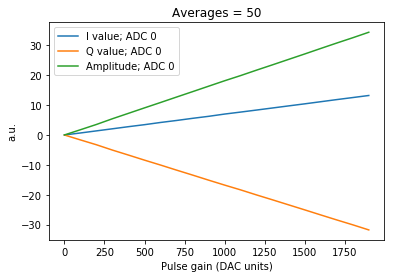

In [6]:
# Plot results.
sig = avgi[0][0] + 1j*avgq[0][0]
avgamp0 = np.abs(sig)
plt.figure(1)
plt.plot(expt_pts, avgi[0][0], label="I value; ADC 0")
plt.plot(expt_pts, avgq[0][0], label="Q value; ADC 0")
plt.plot(expt_pts, avgamp0, label="Amplitude; ADC 0")
# plt.plot(expt_pts, avg_di1, label="I value; ADC 1")
# plt.plot(expt_pts, avg_dq1, label="Q value; ADC 1")
# plt.plot(expt_pts, avg_amp1, label="Amplitude; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Pulse gain (DAC units)")
plt.title("Averages = " + str(config["reps"]))
plt.legend()
plt.savefig("images/Gain_sweep.pdf", dpi=350)

### Sweeping via a Python outer loop

In [7]:
config={"res_ch":6, # --Fixed
        "ro_ch":0, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":100, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":0, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "reps":50, 
       }

sweep_cfg={"start":0, "step":100, "expts":20}
gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])

results=[]
for g in tqdm(gpts):
    config["pulse_gain"]=int(g)
    prog =LoopbackProgram(soccfg, config)
    results.append(prog.acquire(soc, load_pulses=True))
results=np.transpose(results)

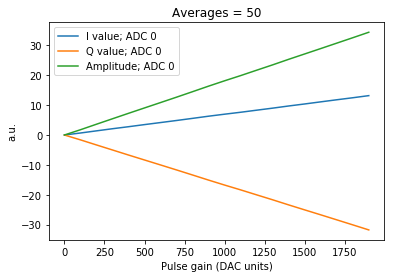

In [8]:
sig = results[0][0][0] + 1j*results[0][0][1]
avgamp0 = np.abs(sig)
plt.figure(2)
plt.plot(gpts, results[0][0][0],label="I value; ADC 0")
plt.plot(gpts, results[0][0][1],label="Q value; ADC 0")
plt.plot(gpts, avgamp0,label="Amplitude; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Pulse gain (DAC units)")
plt.title("Averages = " + str(config["reps"]))
plt.legend()
plt.savefig("images/Gain_sweep_python.pdf", dpi=350)